In [1]:
import argparse
from typing import Any, Dict
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger
import matplotlib.pyplot as plt
import numpy as np
from utils import load_config
from model.Traj_UNet import Guide_UNet2
from utils.data_utils import TrafficDataset
from traffic.core import Traffic
from traffic.algorithms.generation import Generation
from sklearn.preprocessing import MinMaxScaler
from utils.condition_utils import load_conditions



def load_and_prepare_data(configs):
    """
    Load and prepare the dataset for the model.
    """
    dataset_config = configs['data']
    dataset = TrafficDataset.from_file(
        dataset_config["data_path"],
        features=dataset_config["features"],
        shape=dataset_config["data_shape"],
        scaler=MinMaxScaler(feature_range=(-1, 1)),
        info_params={
            "features": dataset_config["info_features"],
            "index": dataset_config["info_index"],
        },
        conditional_features = load_conditions(dataset_config) ,
        down_sample_factor=dataset_config["down_sample_factor"],
    )
    traffic = Traffic.from_file(dataset_config["data_path"])

    return dataset, traffic

def get_checkpoint_path(logger_config: Dict[str, Any]):
    """
    Get the path to the checkpoint file.
    """
    run_name = logger_config["run_name"]
    artifact_location = logger_config["artifact_location"]
    # check that the artifact location exists, otherwise raise an error
    if not os.path.exists(artifact_location):
        raise FileNotFoundError(f"Artifact directory {artifact_location} not found!")

    artifact_location = os.path.join(artifact_location, run_name)
    # check that artifact location exists, otherwise raise an error
    if not os.path.exists(artifact_location):
        raise FileNotFoundError(f"Artifact location {artifact_location} not found!")

    # get the "best_model.ckpt" file
    checkpoint = os.path.join(artifact_location, "best_model.ckpt")
    # check that the checkpoint exists, otherwise raise an error
    if not os.path.exists(checkpoint):
        raise FileNotFoundError(f"Checkpoint file {checkpoint} not found!")

    return checkpoint

def get_models(model_config, dataset_params, checkpoint_path, dataset_scaler):
    """
    Load the trained model and create the trajectory generation model.
    """
    #model = Guide_UNet2.load_from_checkpoint(checkpoint_path, map_location=torch.device('cuda'))
    model = Guide_UNet2.load_from_checkpoint(checkpoint_path, dataset_params = dataset_params, config = model_config)
    model.eval()  # Set the model to evaluation mode
    print("Model loaded with checkpoint!")
    
    """
    trajectory_generation_model = Generation(
        generation=trained_model,
        features=trained_model.hparams.dataset_params["features"],
        scaler=dataset_scaler,
    )
    """
    print("Trajectory generation model created!")

    return model

def get_config_data(config_path: str, data_path: str, artifact_location: str):
    configs = load_config(config_path)
    configs["data"]["data_path"] = data_path 
    configs["logger"]["artifact_location"] = artifact_location
    
    dataset, traffic = load_and_prepare_data(configs)

    condition_config = configs["data"]

    if dataset.conditional_features is None:
        conditions = load_conditions(condition_config, dataset)
    else:
        conditions = dataset.conditional_features

    return configs, dataset, traffic, conditions

def generate_samples(model, n, c_, t):
    raise NotImplementedError("Juhu")



config_file = "./configs/config.yaml"
data_path = "./data/OpenSky_EHAM_LIMC.pkl"
artifact_location= "./artifacts"
checkpoint = "./artifacts/AirDiffTraj/best_model.ckpt"


config = load_config(config_file)
checkpoint = f"./artifacts/AirDiffTraj/best_model.ckpt"
#checkpoint_path = get_checkpoint_path(config["logger"])
config, dataset, traffic, conditions = get_config_data(config_file, data_path, artifact_location)
config['model']["traj_length"] = dataset.parameters['seq_len']

model = get_models(config["model"], dataset.parameters, checkpoint, dataset.scaler)

X, con, cat = dataset[3]
print(con.shape, cat.shape)


# Download and load the training dataset
dataset_config = config["data"]
batch_size = dataset_config["batch_size"]
#train_dataset = FashionMNIST(root='./data', train=True, transform=transform)




(6592, 620)
Continuous conditions:  2
Categorical conditions:  2
torch.Size([6592, 4]) torch.Size([6592, 2])
Model loaded with checkpoint!
Trajectory generation model created!
torch.Size([4]) torch.Size([2])


In [2]:
x, con, cat = dataset[0]
con = con.reshape(1, -1)
cat = cat.reshape(1, -1)
#x = x.view(-1, 1, 28, 28)
n = 1000
length = 155
samples, steps = model.sample(n, con, cat, length)
#print(samples)
print(samples.shape)
print(len(steps))

/home/olavfpl/SynTraj/syntraj/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([1000, 4, 155])
10


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import traffic.core as tc

def plot_from_array(t):
    # Check if the input data has the correct shape
    #if data.shape[1] != 2:
     #   raise ValueError("The second dimension of the array must have a size of 2 for x and y coordinates.")
    
  # Length of each x and y data series
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(12, 12))

    #for i in range(n):
        #x = data[i, 0, :]  # Extract the x values for the i-th series
        #y = data[i, 1, :]  # Extract the y values for the i-th series
        
        #plt.scatter(x, y, label=f'Series {i+1}')  # Plot each series with a label

    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.EuroPP())
    ax1.coastlines()
    t.plot(ax1, alpha=0.5, color="red", linewidth=1)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Plot of X and Y Data from Array')
    plt.show()

detached_s = samples.cpu().detach().numpy()


In [4]:
from traffic.algorithms.generation import Generation

trajectory_generation_model = Generation(
    generation=model,
    features=dataset.parameters['features'],
    scaler=dataset.scaler,
)

In [5]:
print(detached_s.shape)
reco_x = detached_s.transpose(0, 2, 1).reshape(detached_s.shape[0], -1)
decoded = dataset.scaler.inverse_transform(reco_x)
reconstructed_traf = trajectory_generation_model.build_traffic(
    decoded,
    coordinates=dict(latitude=48.5, longitude=8.4),
    forward=False,
)

(1000, 4, 155)


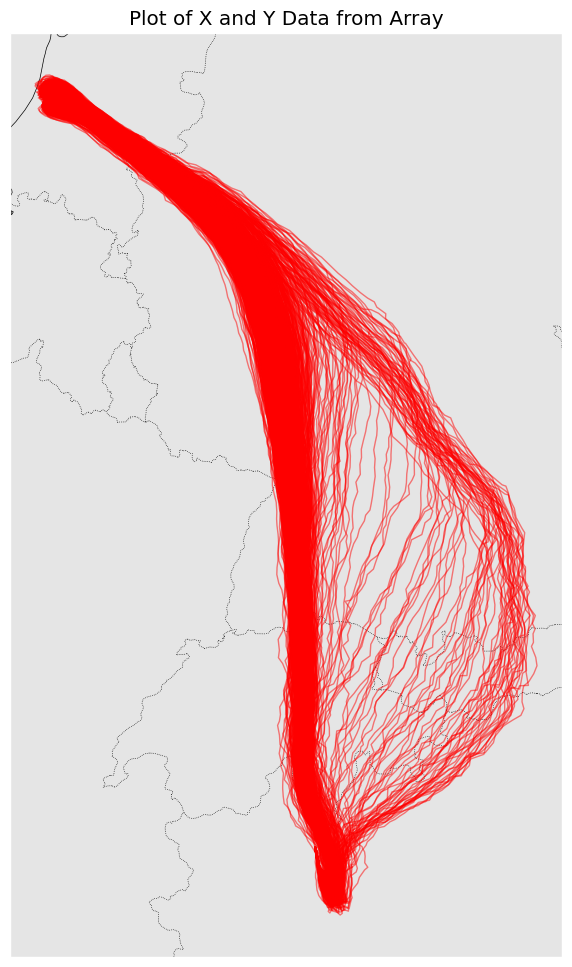

In [6]:
reconstructed_traf
plot_from_array(reconstructed_traf)

(100, 4, 155)


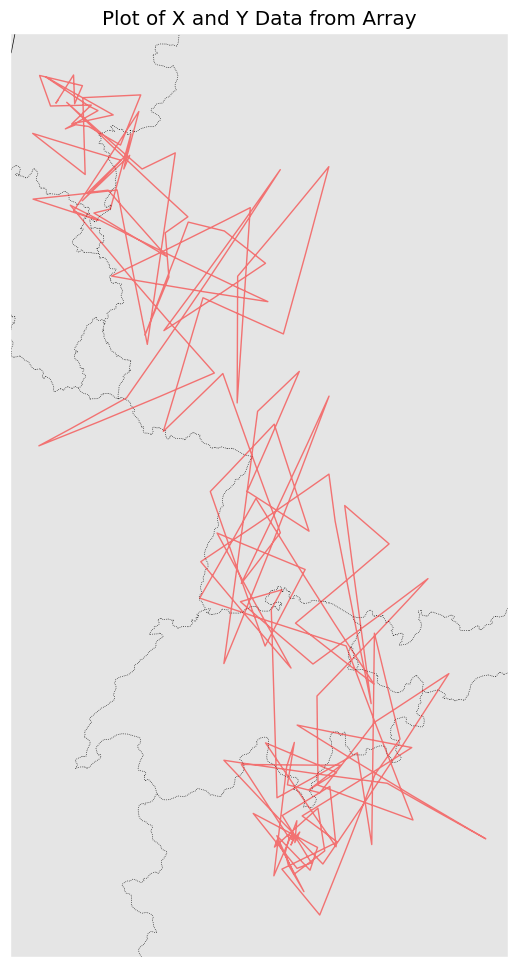

(100, 4, 155)


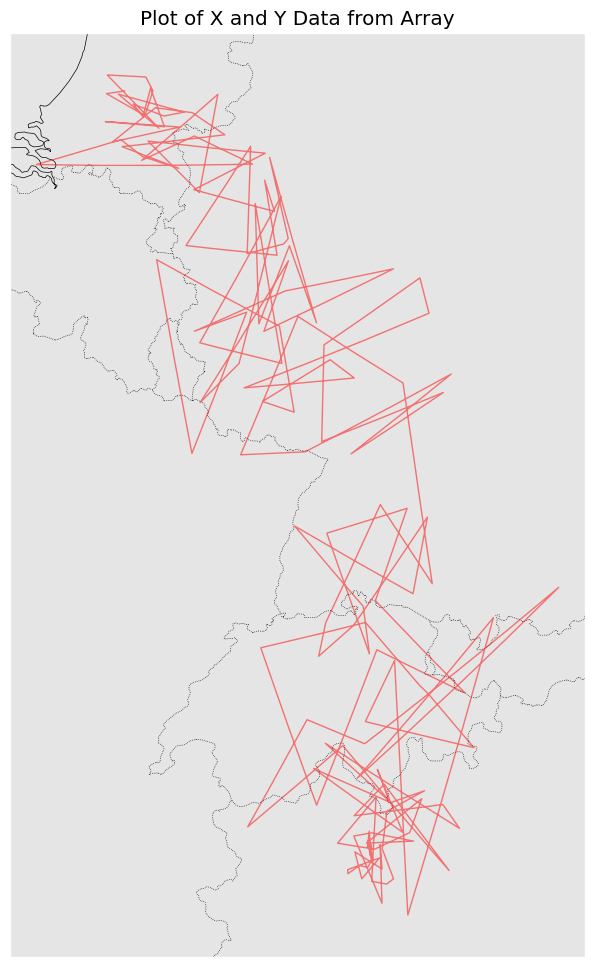

(100, 4, 155)


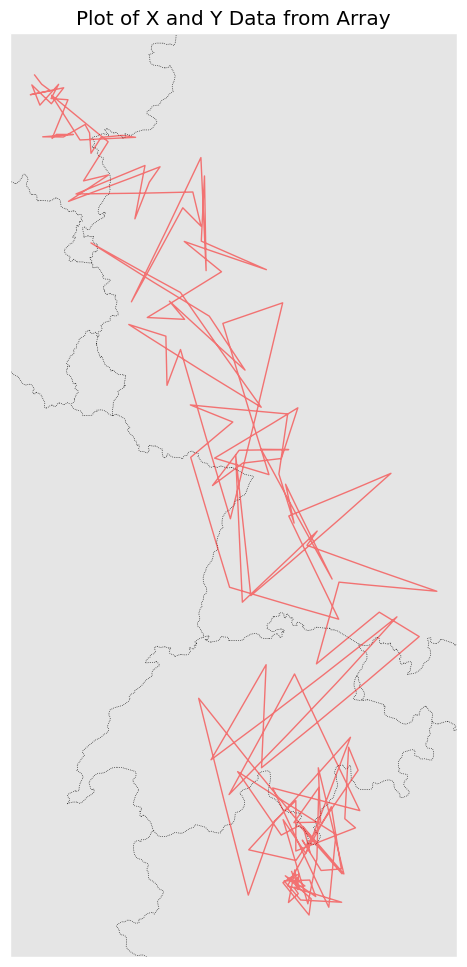

(100, 4, 155)


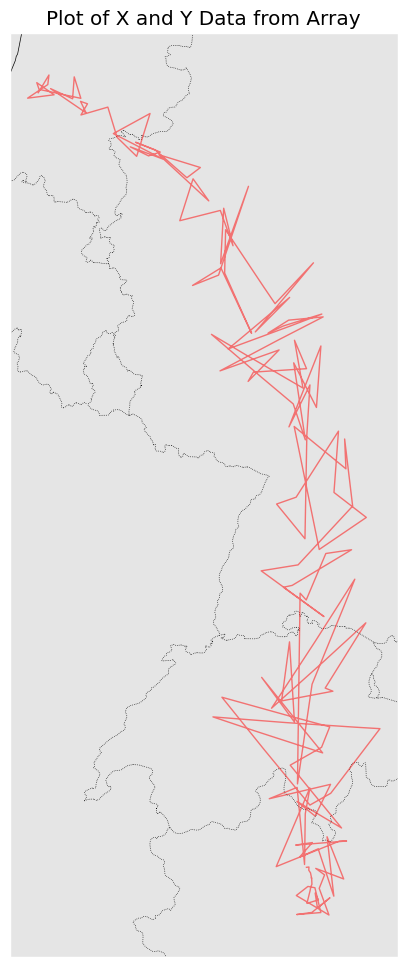

(100, 4, 155)


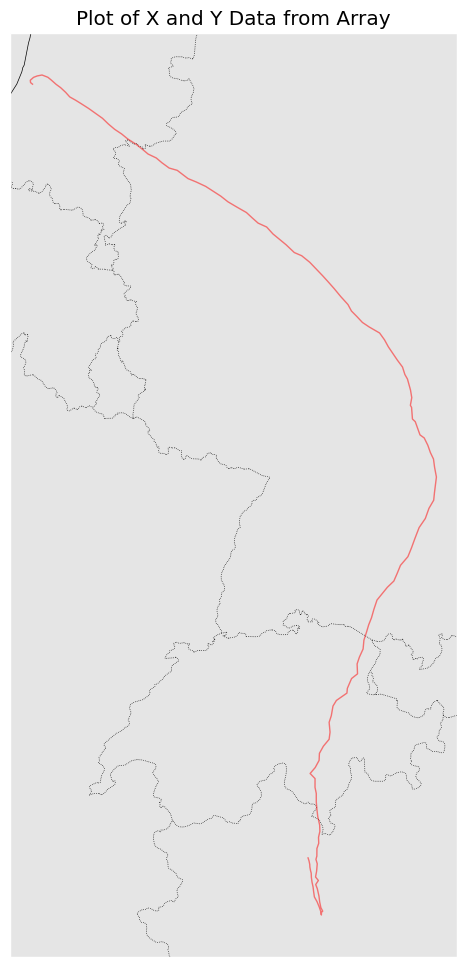

In [10]:
for i in steps:
    print(i.cpu().numpy().shape)
    i = i.cpu().numpy()
    reco_x = i.transpose(0, 2, 1).reshape(i.shape[0], -1)
    decoded = dataset.scaler.inverse_transform(reco_x)
    reconstructed_traf = trajectory_generation_model.build_traffic(
    decoded[0].reshape(1, -1, 4),
    coordinates=dict(latitude=48.5, longitude=8.4),
    forward=False,
    )
    plot_from_array(reconstructed_traf)

(100, 4, 155)
(100, 155, 4)


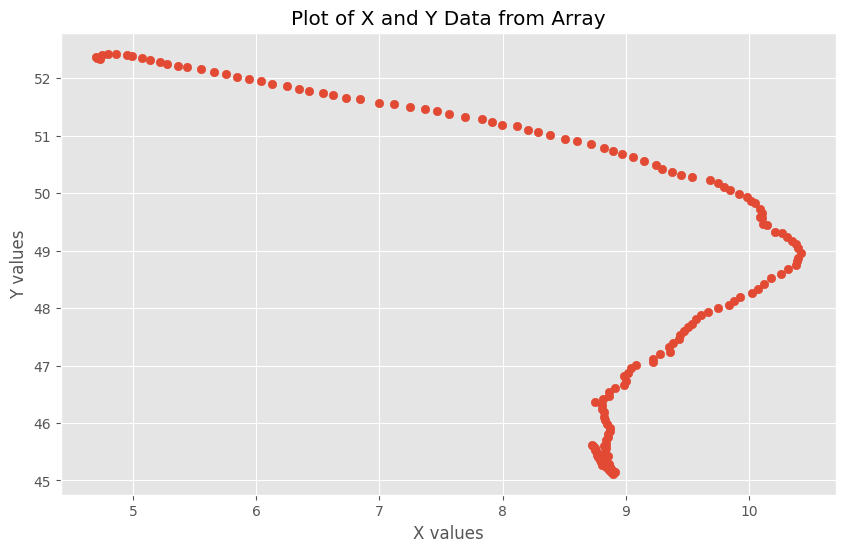

In [34]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
def plot_from_array(data):
    # Check if the input data has the correct shape
    #if data.shape[1] != 2:
     #   raise ValueError("The second dimension of the array must have a size of 2 for x and y coordinates.")
    
  # Length of each x and y data series
    n = data.shape[0]
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(10, 6))

    for i in range(n):
        y = data[i, :, 0]  # Extract the x values for the i-th series
        x = data[i, :, 1]  # Extract the y values for the i-th series
        
        plt.scatter(x, y, label=f'Series {i+1}')  # Plot each series with a label

    #ax1 = fig.add_subplot(1, 1, 1)
    #ax1.coastlines()
    #t.plot(ax1, alpha=0.1, color="red", linewidth=0.2)
    #ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.title('Plot of X and Y Data from Array')
    plt.show()
    
scaler = dataset.scaler
print(detached_s.shape)

detached_w = detached_s.transpose(0, 2, 1).reshape(detached_s.shape[0], -1)
detached_w = scaler.inverse_transform(detached_w).reshape(100, -1, 4)


print(detached_w.shape)

plot_from_array(detached_w[:1, :, :2])

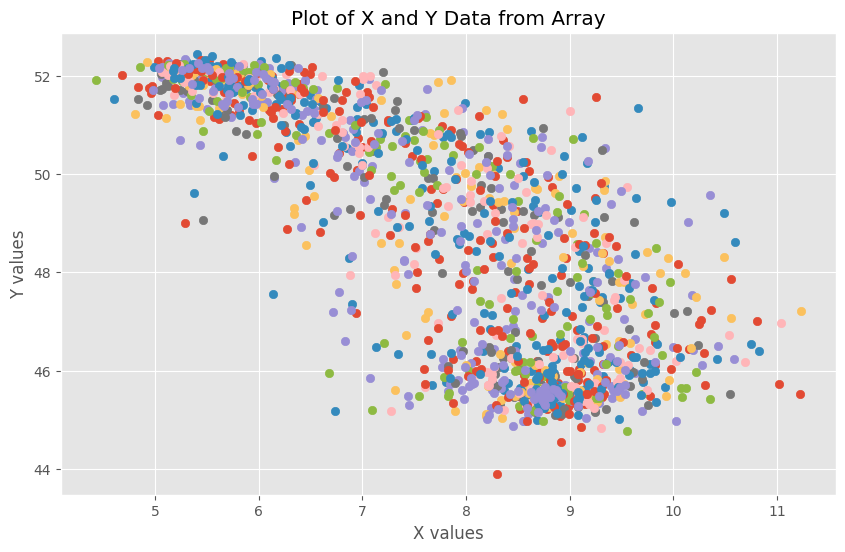

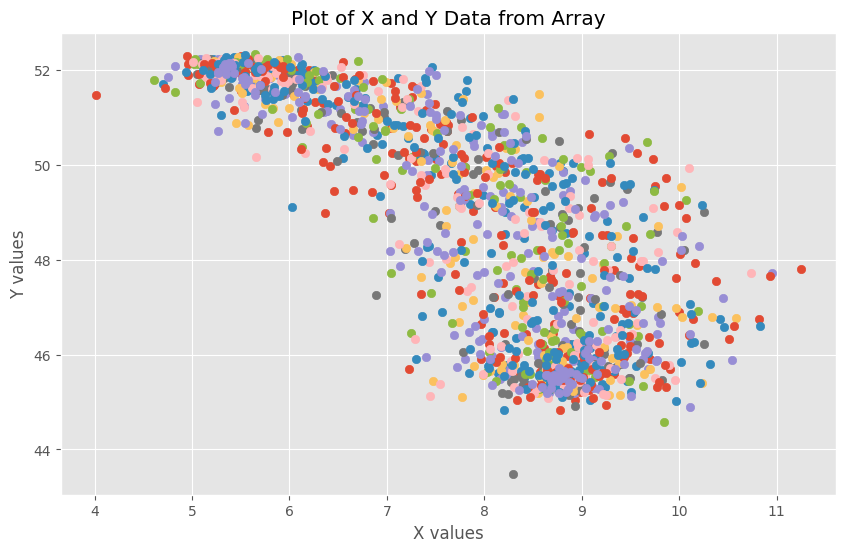

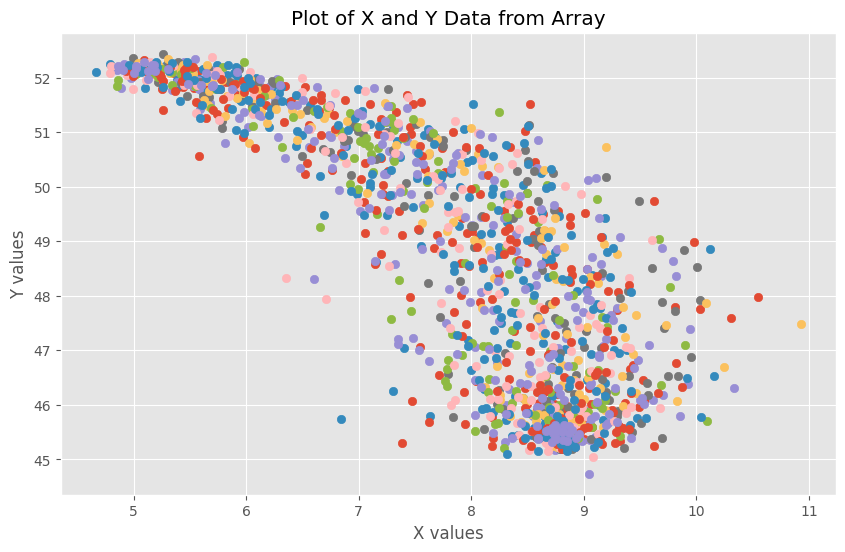

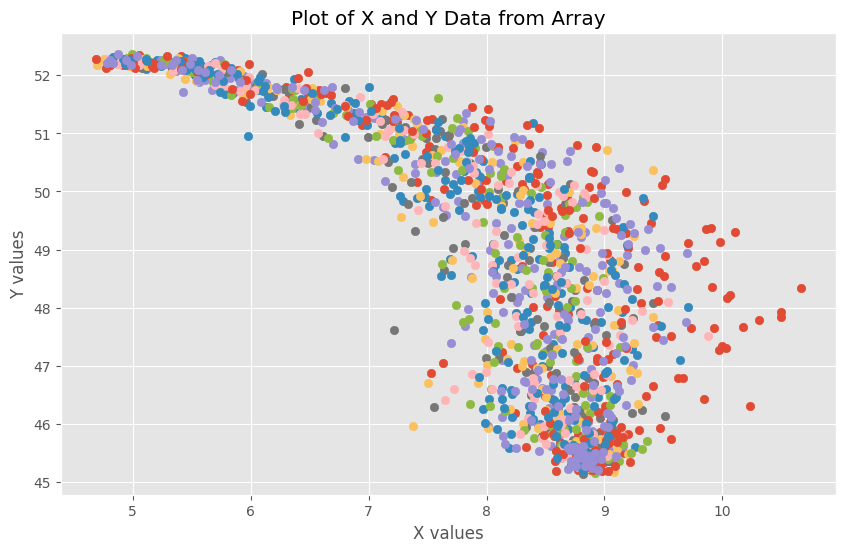

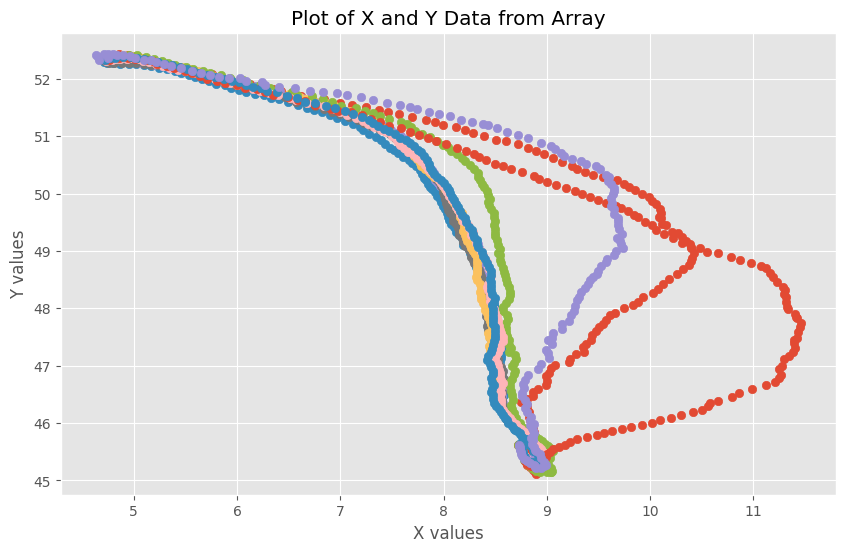

In [36]:
for i in steps:
    scaler = dataset.scaler
    i = i.cpu().numpy()
    #print(detached_s.shape)
    detached_w = i.transpose(0, 2, 1).reshape(i.shape[0], -1)
    detached_w = scaler.inverse_transform(detached_w).reshape(100, -1, 4)
    #print(detached_w.shape)
    
    plot_from_array(detached_w[:10, :, :2])

In [ ]:
t = Traffic.from_file(data_path)[:10]


In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
#t.plot(ax)

#plt.plot(data_2[0], data_2[1])

ax = fig.add_subplot(1, 1, 1, projection=ccrs.EuroPP())
ax.coastlines()
t.plot(ax, alpha=0.5, color="red", linewidth=1)
ax.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Plot of X and Y Data from Array')
plt.show()

In [ ]:
t.data

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(10, 6))
print(dataset.features)

data = t.data[dataset.features].to_numpy().reshape(10, -1, 4)
print(data.shape)
for i in range(10):
    x = data[i,:, 0]  # Extract the x values for the i-th series
    y = data[i,:, 1]  # Extract the y values for the i-th series
    plt.scatter(x, y, label=f'Series {1}')  # Plot each series with a label

#plt.plot(data_2[0], data_2[1])

#ax1 = fig.add_subplot(1, 1, 1)
#ax1.coastlines()
#t.plot(ax1, alpha=0.1, color="red", linewidth=0.2)
#ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Plot of X and Y Data from Array')
plt.show()

In [ ]:
scaler = MinMaxScaler((-1, 1))
data_org = t.data[dataset.features]
scaler.fit(data_org)
#print(t.data.shape)
data = scaler.transform(data_org)
#data = t.data[dataset.features].to_numpy()
data_2 = scaler.inverse_transform(data)  # No reshaping here
data_2 = data_2.reshape(10, -1, 4)       # Reshape after inverse_transform
data = data.reshape(10,-1, 4)
plt.style.use("ggplot")
fig = plt.figure(figsize=(10, 6))
for i in range(10):
    x = data[i,:,0]  # Extract the x values for the i-th series
    y = data[i,:, 1]  # Extract the y values for the i-th series
    plt.plot(x, y, label=f'Series {1}')  # Plot each series with a label
    x = data_2[i,:, 0]  # Extract the x values for the i-th series
    y = data_2[i,:, 1]  # Extract the y values for the i-th series
    plt.plot(x, y, label=f'Series {1}')  # Plot each series with a label

#plt.plot(data_2[0], data_2[1])

#ax1 = fig.add_subplot(1, 1, 1)
#ax1.coastlines()
#t.plot(ax1, alpha=0.1, color="red", linewidth=0.2)
#ax1.add_feature(cartopy.feature.BORDERS, linestyle=":", alpha=1.0)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Plot of X and Y Data from Array')
plt.show()